In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Double Well Potential: Metropolis

Consider a double-well potential:
$$U(x) = \gamma (x^2-1)^2,~~~~\gamma > 0$$

and a corresponding probability distribution:
$$\pi(x) \propto \exp(-U(x)).$$


In [2]:
def U(x, gamma):
  """Eqn 1 as function of x and gamma"""
  return gamma * (x**2-1)**2

def pU(x, gamma):
  """Eqn 2 as function of x and gamma"""
  return np.exp(-U(x,gamma))

def metro_proposal(xc, delta):
    """symmetric normal distribution"""
    return np.random.normal(xc, delta)

def metro_accept(xn, pc, f, gamma):
    acc = False
    pn  = f(xn, gamma)

    ratio = pn/pc

    if ratio > 1.:
        acc = True
    elif np.random.rand() < ratio:
        acc = True
    return acc, pn

def metropolis(x0, gamma, delta=0.25, nsteps=20000, thin=10):
    """main MCMC routine"""

    # initialize x and f(x)
    x = x0
    f = pU(x, gamma)

    AccRatio = 0.0
    NumSucc = 0

    # record values of "x"
    recz = np.zeros(int(nsteps/thin))

    # main loop
    for iMCS in range(nsteps):
        newx = metro_proposal(x, delta)
        accept, newf = metro_accept(newx, f, pU, gamma)

        if accept:
            NumSucc += 1
            x = newx
            f = newf

        if (iMCS % thin) == 0:
            recz[int(iMCS/thin)] = x

    AccRatio = float(NumSucc)/float(nsteps)
    return recz, AccRatio

def plotSimRun(x, gamma):
    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_size_inches(11, 5)
    ax1.plot(x,'-')
    ax1.set_xlabel('MCS',fontsize=18)
    ax1.set_ylabel('$x_i$',fontsize=18)

    ax2.hist(x, 50, density=True)
    xlim = max(np.abs(x))
    xi = np.linspace(-xlim,xlim,500)
    p = pU(xi, gamma); p = p/np.trapz(p,xi)

    ax2.plot(xi, p)
    ax2.set_xlabel('$x$',fontsize=18)
    ax2.set_ylabel('$\pi(x)$',fontsize=18)
    ax2.set_xticks([-2, -1, 0, 1, 2])

    f.tight_layout()

In [3]:
gam = 8.0
x, AccRatio = metropolis(x0=0., gamma=gam, delta=1.0, nsteps=20000, thin=10)
print(AccRatio)

0.19415


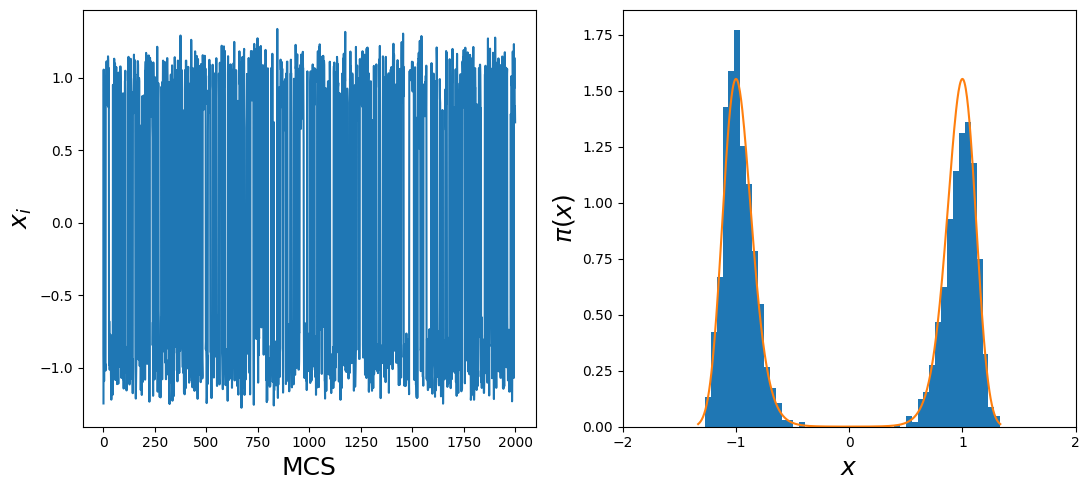

In [4]:
plotSimRun(x, gam)

# MC3

In [5]:
def pU(x, gamma):
    return np.exp(-gamma * (x**2-1)**2)

def metro_proposal(xc, delta):
    return np.random.normal(xc, delta)

def metro_accept(xn, pc, f, gamma, invTemp):
    """acceptance for within-chain proposals;
    xn = proposed state
    fc = probability of current state
    f, gamma = identity of function to be sampled
    the factor a = 1/T = invTemp"""

    acc = False
    pn  = f(xn, gamma)

    ratio = (pn/pc)**invTemp

    if ratio > 1.:
        acc = True
    elif np.random.rand() < ratio:
        acc = True

    return acc, pn

def proposeSwap(nchain):

    i = np.random.randint(nchain)

    if np.random.rand() < 0.5:
        j = i + 1
    else:
        j = i - 1

    if j < 0:
        j = 0
    elif j > nchain-1:
        j = nchain-1

    return i, j

def swap_accept(fi, fj, ai, aj):
    """should I accept the swap between chain i and j"""

    factor = fj**(ai-aj) * fi**(aj-ai)

    if np.random.rand() <= factor:
        swap = True
    else:
        swap = False

    return swap

In [6]:
def mcmcmc(x0, a, gamma = 16., delta = 0.25, nsteps = 1000, thin = 10, nFreqSwap = 10):

    nchain   = len(a)
    z        = np.ones((nchain,1)) * x0
    fz       = pU(z, gamma)

    recz 	 = np.zeros((int(nsteps/thin), nchain))          # record cold chain trajectory
    recz[0]  = z.reshape((1,nchain))

    nSucInt  = np.zeros((nchain));
    nSucExc  = np.zeros((nchain-1));

    # regular long cycle
    for iMCS in range(1,nsteps):

        # cycle through temperatures
        for iTemp in range(nchain):

            x = z[iTemp]                    # present value of a Markov Chain
            f = fz[iTemp]

            newx = metro_proposal(x, delta)
            accept, newf = metro_accept(newx, f, pU, gamma, a[iTemp])

            if accept:
                z[iTemp]  = newx
                fz[iTemp] = newf

                nSucInt[iTemp] += 1

        # try swapping
        if iMCS  % nFreqSwap == 0:

            i, j = proposeSwap(nchain)
            if i != j:
                accept = swap_accept(fz[i], fz[j], a[i], a[j])

                if accept:
                    nSucExc[min(i,j)] += 1

                    tmp = z[i];  tmpf  = fz[i]
                    z[i] = z[j]; fz[i] = fz[j]
                    z[j] = tmp;  fz[j] = tmpf

        # printing
        if iMCS % thin == 0:
            recz[int(iMCS/thin),:] = z.reshape((1,nchain))

    print("Intra-chain # success rates", nSucInt)

    print("# Success for Exchange involving chain", nSucExc)

    return recz, nSucInt, nSucExc

In [7]:
a = np.array([1.0, 0.0001])
gam = 32.0

# case without swapping; 4 chains in parallel
recz, ar_int, ar_exc=mcmcmc(0., a, nsteps=50000, nFreqSwap = 100)

Intra-chain # success rates [19899. 48276.]
# Success for Exchange involving chain [26.]


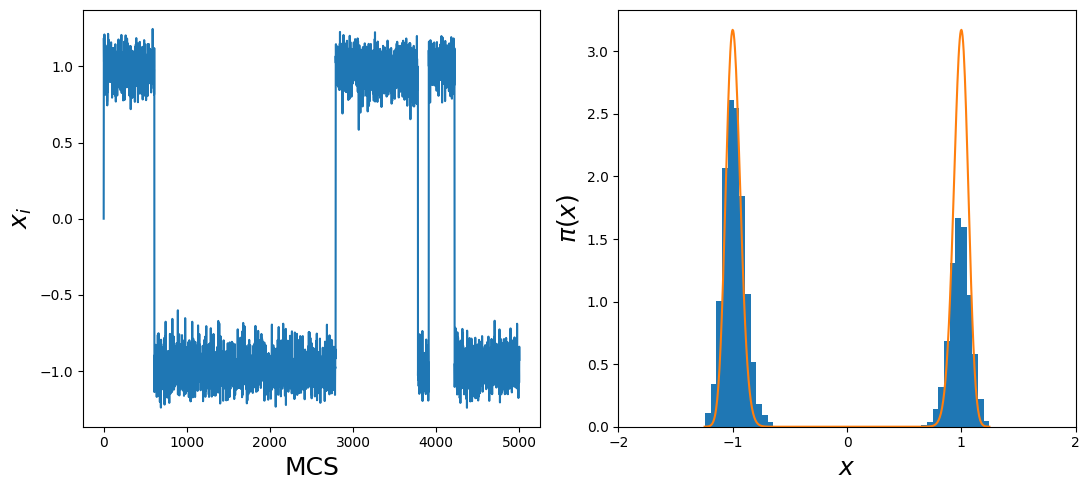

In [8]:
j = 0; plotSimRun(recz[:,j], gam*a[j])